# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Cyborg\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import warnings
warnings.filterwarnings("ignore")

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
sorted_data=sorted_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

In [10]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1415.93it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [14]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

## [4.3] TF-IDF

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### [4.4.1.2] TFIDF weighted W2v

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [15]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
X=preprocessed_reviews[:]
y=final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
bow = CountVectorizer()
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
# print(X_train_bow.shape, y_train.shape)


depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(RandomForestClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(X_train_bow, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_bow)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

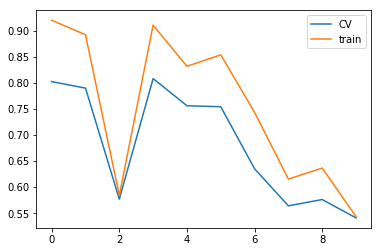

In [17]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  5
Best value of min_samples_split:  100


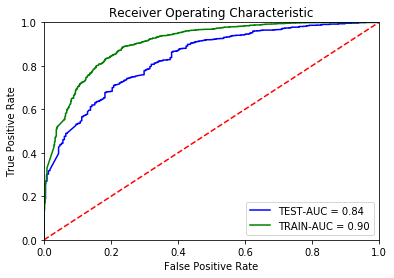

In [18]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=RandomForestClassifier(n_estimators= estimator , max_depth=depth)
model.fit(X_train_bow, y_train)
w=model.feature_importances_
pred1=model.predict_proba(X_test_bow)[:,1]
pred2=model.predict_proba(X_train_bow)[:,1]
score1=roc_auc_score(y_test, pred1)
score2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % score1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % score2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

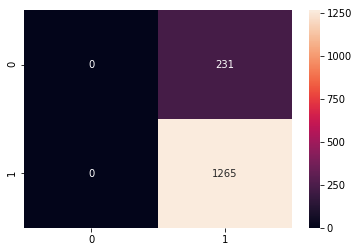

In [19]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [20]:
bow_features=bow.get_feature_names()
from wordcloud import WordCloud, STOPWORDS 

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

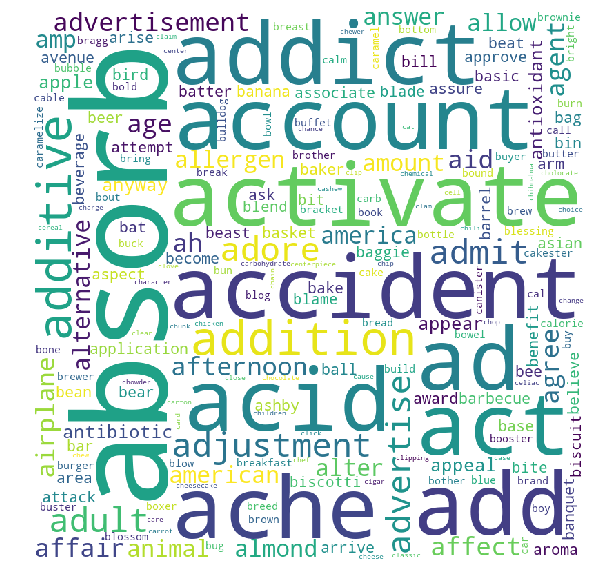

In [21]:
# Please write all the code with proper documentation
# Copied from wordcloud documentation
comment_words = ' '
for val in bow_features: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '


stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [22]:
# Please write all the code with proper documentation
X=preprocessed_reviews[:]
y=final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
tfidf = TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)
tfidf_features=tfidf.get_feature_names()
depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(RandomForestClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(X_train_tfidf, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_tfidf)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

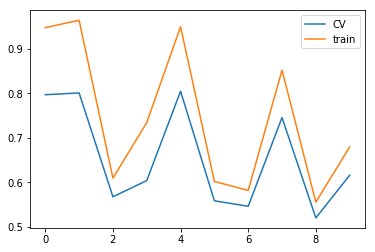

In [23]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  5
Best value of min_samples_split:  100
ROC SCORE ON BEST HYPER-PARAMETERS:  0.5


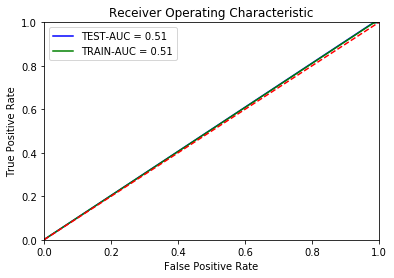

In [24]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=RandomForestClassifier(n_estimators= estimator , max_depth=depth)
model.fit(X_train_bow, y_train)
w=model.feature_importances_
pred1=model.predict_proba(X_test_tfidf)[:,1]
pred2=model.predict_proba(X_train_tfidf)[:,1]
score_1=roc_auc_score(y_test, pred1)
score_2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score)
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

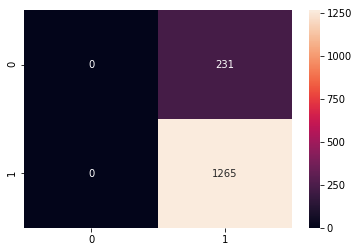

In [25]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

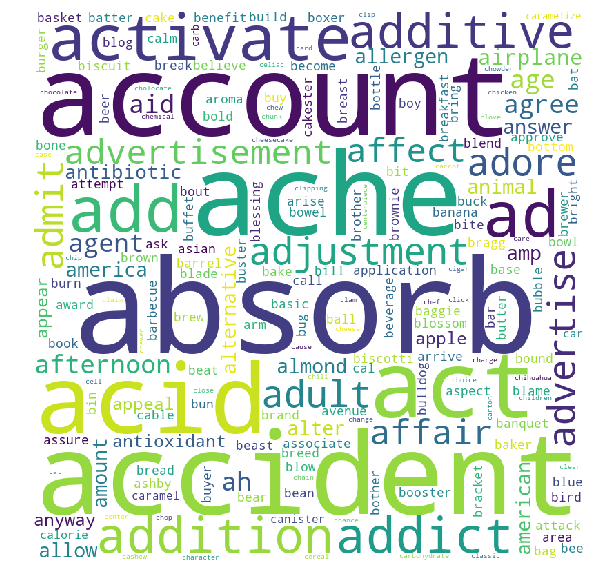

In [26]:
# Please write all the code with proper documentation
# Copied from wordcloud documentation
comment_words = ' '
for val in tfidf_features: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '


stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [27]:
from gensim.models import Word2Vec
import gensim

In [28]:
list_sent=[]
for sent in preprocessed_reviews:
    list_sent.append(sent.split())
X=preprocessed_reviews[:]
y=final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)

w2v_model=gensim.models.Word2Vec(X_train,min_count=5, size=50)
w2v_words = list(w2v_model.wv.vocab)

# Then vectorize your train model as
sent_vectors_train = [];
for sent in tqdm(X_train):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

# And then vectorize test as

sent_vectors_test = [];
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: #
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:02<00:00, 637.92it/s]


In [29]:
depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(RandomForestClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(sent_vectors_train, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(sent_vectors_train)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

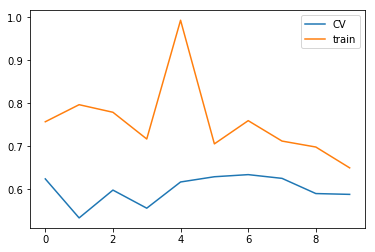

In [30]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  5
Best value of min_samples_split:  100
ROC SCORE ON BEST HYPER-PARAMETERS:  0.6127200862378728


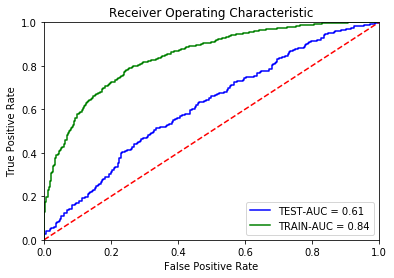

In [60]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=RandomForestClassifier(n_estimators= estimator , max_depth=depth)
model.fit(sent_vectors_train, y_train)
w=model.feature_importances_
pred1=model.predict_proba(sent_vectors_test)[:,1]
pred2=model.predict_proba(sent_vectors_train)[:,1]
score_1=roc_auc_score(y_test, pred1)
score_2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score_1)
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

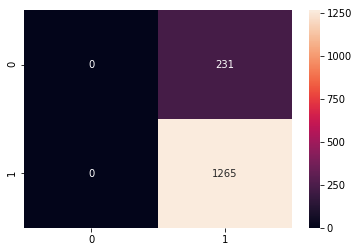

In [61]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [33]:
# Please write all the code with proper documentation

In [34]:
list_sent=[]
for sent in preprocessed_reviews:
    list_sent.append(sent.split())
X=list_sent[:]
y=final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
w2v_model=gensim.models.Word2Vec(X_train,min_count=5, size=50)
w2v_words = list(w2v_model.wv.vocab)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_train:
    # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_features:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_sent_vectors_test = []; 

row=0;
for sent in X_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_features:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    

In [35]:
depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(RandomForestClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(tfidf_sent_vectors_train, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(tfidf_sent_vectors_train)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

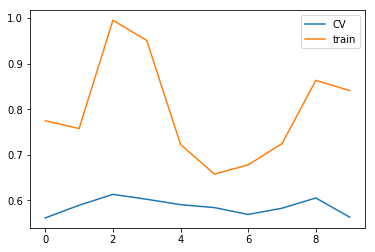

In [36]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  9
Best value of min_samples_split:  100
ROC SCORE ON BEST HYPER-PARAMETERS:  0.6099652653012336


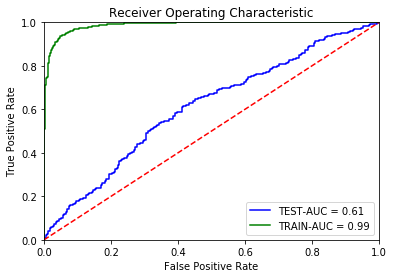

In [37]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=RandomForestClassifier(n_estimators= estimator , max_depth=depth)
model.fit(tfidf_sent_vectors_train, y_train)
w=model.feature_importances_
pred1=model.predict_proba(tfidf_sent_vectors_test)[:,1]
pred2=model.predict_proba(tfidf_sent_vectors_train)[:,1]
score_1=roc_auc_score(y_test, pred1)
score_2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())


print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score_1)
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

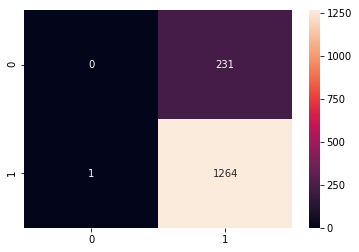

In [38]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [39]:
# Please write all the code with proper documentation
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
import xgboost as xgb
from xgboost import XGBClassifier

In [40]:
depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(XGBClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(X_train_bow, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_bow)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

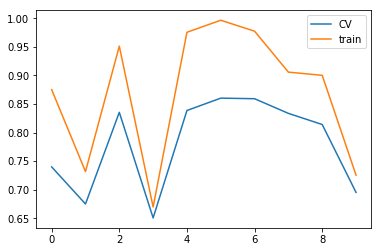

In [41]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  9
Best value of min_samples_split:  100
ROC SCORE ON BEST HYPER-PARAMETERS:  0.8919288879763188


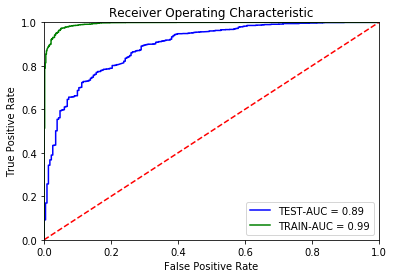

In [42]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=XGBClassifier(n_estimators= estimator , max_depth=depth)
model.fit(X_train_bow, y_train)

pred1=model.predict_proba(X_test_bow)[:,1]
pred2=model.predict_proba(X_train_bow)[:,1]
score_1=roc_auc_score(y_test, pred1)
score_2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())
print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score_1)
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

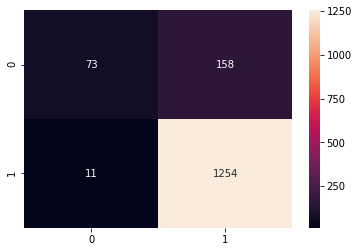

In [43]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [44]:
# Please write all the code with proper documentation

In [45]:
depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(XGBClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(X_train_tfidf, y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(X_train_tfidf)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

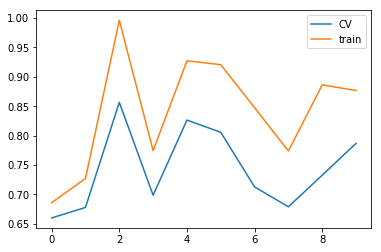

In [46]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  7
Best value of min_samples_split:  100
ROC SCORE ON BEST HYPER-PARAMETERS:  0.8944629810242459


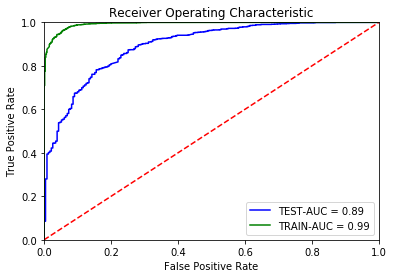

In [47]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=XGBClassifier(n_estimators= estimator , max_depth=depth)
model.fit(X_train_tfidf, y_train)

pred1=model.predict_proba(X_test_tfidf)[:,1]
pred2=model.predict_proba(X_train_tfidf)[:,1]
score_1=roc_auc_score(y_test, pred1)
score_2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())
print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score_1)
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

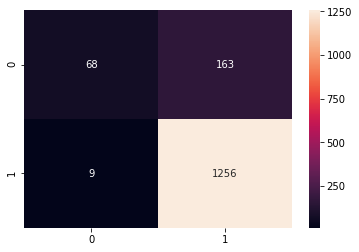

In [48]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [49]:
# Please write all the code with proper documentation|

In [50]:
depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(np.array(sent_vectors_train), y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(sent_vectors_train)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

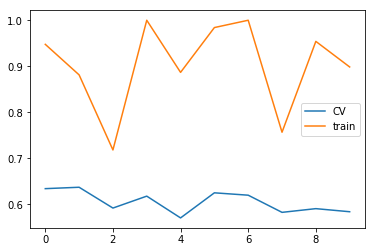

In [51]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  3
Best value of min_samples_split:  50
ROC SCORE ON BEST HYPER-PARAMETERS:  0.6019300857245522


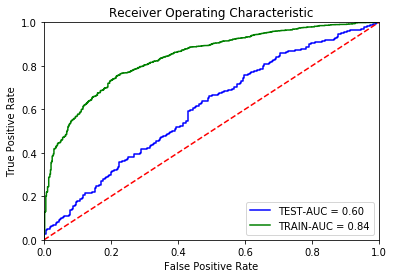

In [52]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=XGBClassifier(n_estimators= estimator , max_depth=depth)
model.fit(np.array(sent_vectors_train), y_train)

pred1=model.predict_proba(sent_vectors_test)[:,1]
pred2=model.predict_proba(sent_vectors_train)[:,1]
score_1=roc_auc_score(y_test, pred1)
score_2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())
print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score_1)
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

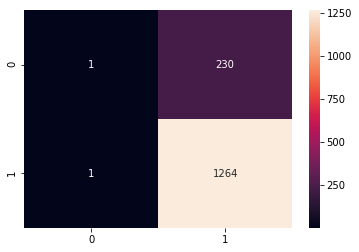

In [53]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [54]:
# Please write all the code with proper documentation

In [55]:
depth=[2,3,5,7,9]
base_learners=[2,5,50,100]
parameters=dict(n_estimators=base_learners , max_depth=depth)
clf=RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1) ,parameters, scoring='roc_auc', refit=True, cv=3)

clf.fit(np.array(tfidf_sent_vectors_train), y_train)
cv_error=clf.cv_results_['mean_test_score']
train_error=clf.cv_results_['mean_train_score']
pred=clf.predict(sent_vectors_train)
score=roc_auc_score(y_train, pred)
estimator=clf.best_params_['n_estimators']
depth=clf.best_params_['max_depth']

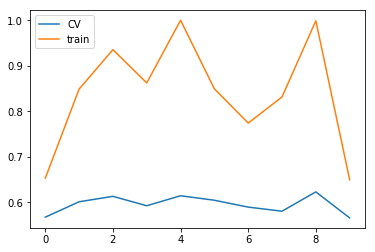

In [56]:
plt.plot(cv_error, label='CV')
plt.plot(train_error, label='train')
plt.legend()
plt.show()

Best value of max_depth:  5
Best value of min_samples_split:  100
ROC SCORE ON BEST HYPER-PARAMETERS:  0.6226442858853927


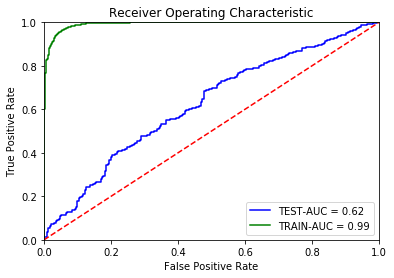

In [57]:
print('Best value of max_depth: ', depth)
print('Best value of min_samples_split: ', estimator)
model=XGBClassifier(n_estimators= estimator , max_depth=depth)
model.fit(np.array(tfidf_sent_vectors_train), y_train)

pred1=model.predict_proba(tfidf_sent_vectors_test)[:,1]
pred2=model.predict_proba(tfidf_sent_vectors_train)[:,1]
score_1=roc_auc_score(y_test, pred1)
score_2=roc_auc_score(y_train, pred2)
cm = confusion_matrix(y_test, pred1.round())
print('ROC SCORE ON BEST HYPER-PARAMETERS: ', score_1)
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred1)
fpr2, tpr2, threshold = metrics.roc_curve(y_train, pred2)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='TEST-AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'TRAIN-AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

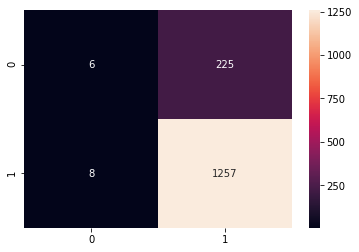

In [58]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# [6] Conclusions

In [59]:
# Please compare all your models using Prettytable library